In [2]:
import pandas as pd
from google.colab import drive
import requests
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url = "https://drive.google.com/uc?id=1Kf0CkP30jL8Wur_z6MX1d5RWWpddYzvC"
local_filename = "ndvi_temporal.csv"

In [4]:
response = requests.get(url)
if response.status_code == 200:
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    print(f"Arquivo salvo como {local_filename}")
else:
    print("Erro ao baixar o arquivo. Código:", response.status_code)

Arquivo salvo como ndvi_temporal.csv


In [5]:
df = pd.read_csv(local_filename)

In [6]:
df.head()

,Sensor,Data,Area,NDVI
0,Landsat 8,2015-12-06,Plantacao,-0.002367
1,Landsat 8,2016-01-07,Plantacao,0.159579
2,Landsat 8,2017-12-11,Plantacao,0.023901
3,Landsat 8,2018-12-30,Plantacao,0.134290
4,Landsat 8,2019-02-16,Plantacao,-0.003367


In [7]:
# Limpeza
df = df.drop(columns=['system:index', '.geo'], errors='ignore')
df['Area'] = df['Area'].astype(str)
df['Sensor'] = df['Sensor'].astype(str)
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d', errors='coerce')
df = df.dropna()

In [8]:
def getDataInfo(dataframe: pd.DataFrame) -> None:
    print("\nDataframe shape: ")
    print(dataframe.shape)
    print("\nDataframe columns: ")
    dataframe.info()
    print("\nDataframe describe: ")
    dataframe.describe()
    print("\nDataframe head: ")
    print(dataframe.head())

In [9]:
getDataInfo(df)


Dataframe shape: 
(1591, 4)

Dataframe columns: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Sensor  1591 non-null   object        
 1   Data    1591 non-null   datetime64[ns]
 2   Area    1591 non-null   object        
 3   NDVI    1591 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 49.8+ KB

Dataframe describe: 

Dataframe head: 
      Sensor       Data       Area      NDVI
0  Landsat 8 2015-12-06  Plantacao -0.002367
1  Landsat 8 2016-01-07  Plantacao  0.159579
2  Landsat 8 2017-12-11  Plantacao  0.023901
3  Landsat 8 2018-12-30  Plantacao  0.134290
4  Landsat 8 2019-02-16  Plantacao -0.003367


In [10]:
tmin = df['Data'].min()
tmax = df['Data'].max()
print(tmin)
print(tmax)
print(f'Variação de tempo: {tmax-tmin}')

2015-06-26 00:00:00
2025-04-07 00:00:00
Variação de tempo: 3573 days 00:00:00


In [11]:
cor_sensor = {
        'Sentinel-2': 'green',
        'MODIS': 'orange',
        'Landsat 8': 'blue'
    }

In [12]:
def plot_ndvi_mensal_por_sensor(df: pd.DataFrame, ano:int) -> None:
    df_ano = df[df['Data'].dt.year == ano].copy()
    df_ano['Mes'] = df_ano['Data'].dt.month
    df_grouped = df_ano.groupby(['Sensor', 'Area', 'Mes'])['NDVI'].mean().reset_index()

    areas = df_grouped['Area'].unique()

    for area in areas:
        plt.figure(figsize=(10, 6))
        dados_area = df_grouped[df_grouped['Area'] == area]
        sensores = dados_area['Sensor'].unique()

        for sensor in sensores:
            dados_sensor = dados_area[dados_area['Sensor'] == sensor]
            cor = cor_sensor.get(sensor, 'black')  # Caso o sensor não esteja no mapeamento, usa preto
            plt.plot(
                dados_sensor['Mes'],
                dados_sensor['NDVI'],
                marker='o',
                label=sensor,
                color=cor
            )
        plt.title(f'Média Mensal do NDVI - {area} - {ano}')
        plt.xlabel('Mês')
        plt.ylabel('NDVI Médio')
        plt.xticks(range(1, 13))
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{area}_{ano}.png')

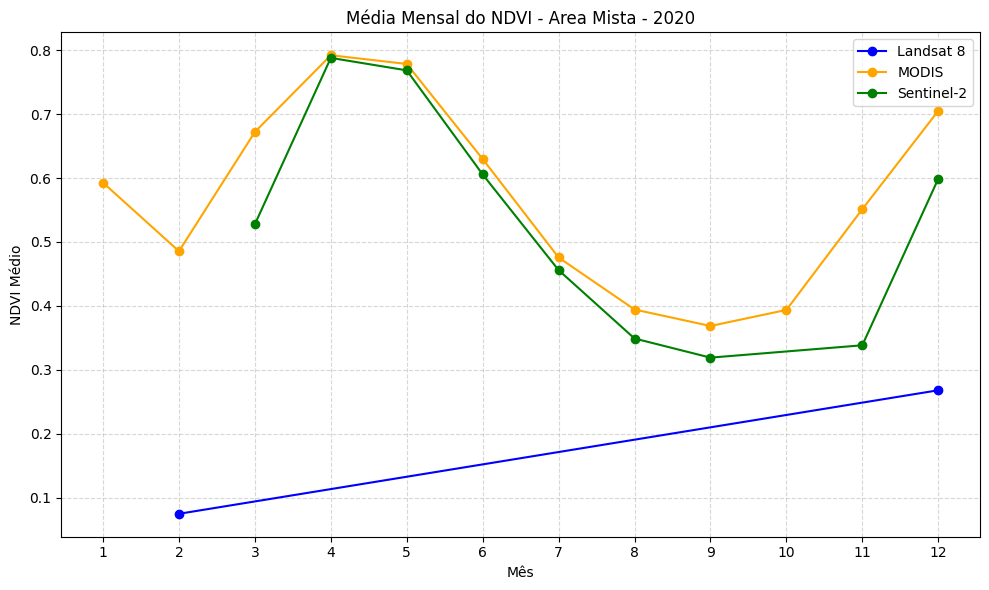

<Figure size 640x480 with 0 Axes>

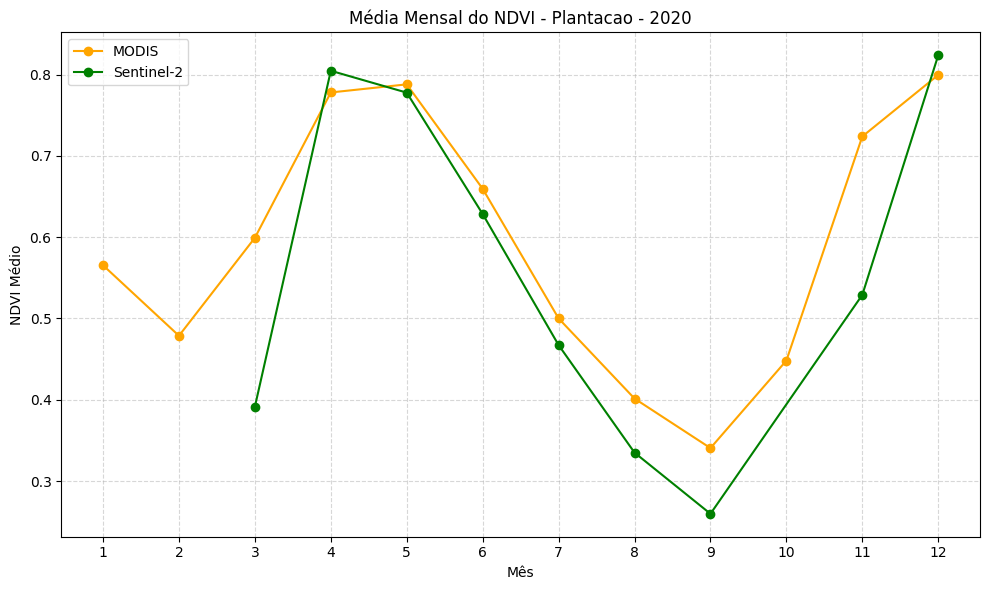

<Figure size 640x480 with 0 Axes>

In [13]:
plot_ndvi_mensal_por_sensor(df, 2020)

In [14]:
def animar_ndvi(df: pd.DataFrame, areas_selecionadas: list[str]) -> FuncAnimation:
    anos = sorted(df['Data'].dt.year.unique())

    fig, axs = plt.subplots(1, len(areas_selecionadas), figsize=(14, 6), sharey=True)
    if len(areas_selecionadas) == 1:
        axs = [axs]

    def init():
        for ax, area in zip(axs, areas_selecionadas):
            ax.clear()
            ax.set_title(f'{area}')
            ax.set_xlabel('Mês')
            ax.set_ylabel('NDVI Médio')
            ax.set_xticks(range(1, 13))
            ax.set_ylim(0, 1)
            ax.grid(True, linestyle='--', alpha=0.5)
        return []

    def update(frame):
        ano = anos[frame]
        df_ano = df[df['Data'].dt.year == ano].copy()
        df_ano['Mes'] = df_ano['Data'].dt.month
        df_grouped = df_ano.groupby(['Sensor', 'Area', 'Mes'])['NDVI'].mean().reset_index()

        for ax, area in zip(axs, areas_selecionadas):
            ax.clear()
            dados_area = df_grouped[df_grouped['Area'] == area]
            sensores = dados_area['Sensor'].unique()

            for sensor in sensores:
                dados_sensor = dados_area[dados_area['Sensor'] == sensor]
                cor = cor_sensor.get(sensor, 'black')
                ax.plot(dados_sensor['Mes'], dados_sensor['NDVI'], marker='o', label=sensor, color=cor)

            ax.set_title(f'{area} - {ano}')
            ax.set_xlabel('Mês')
            ax.set_ylabel('NDVI Médio')
            ax.set_xticks(range(1, 13))
            ax.set_ylim(0, 1)
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend()

        fig.suptitle(f'NDVI Médio Mensal - {ano}', fontsize=16)
        fig.tight_layout()
        return []

    return FuncAnimation(fig, update, frames=len(anos), init_func=init, interval=1000, blit=False)

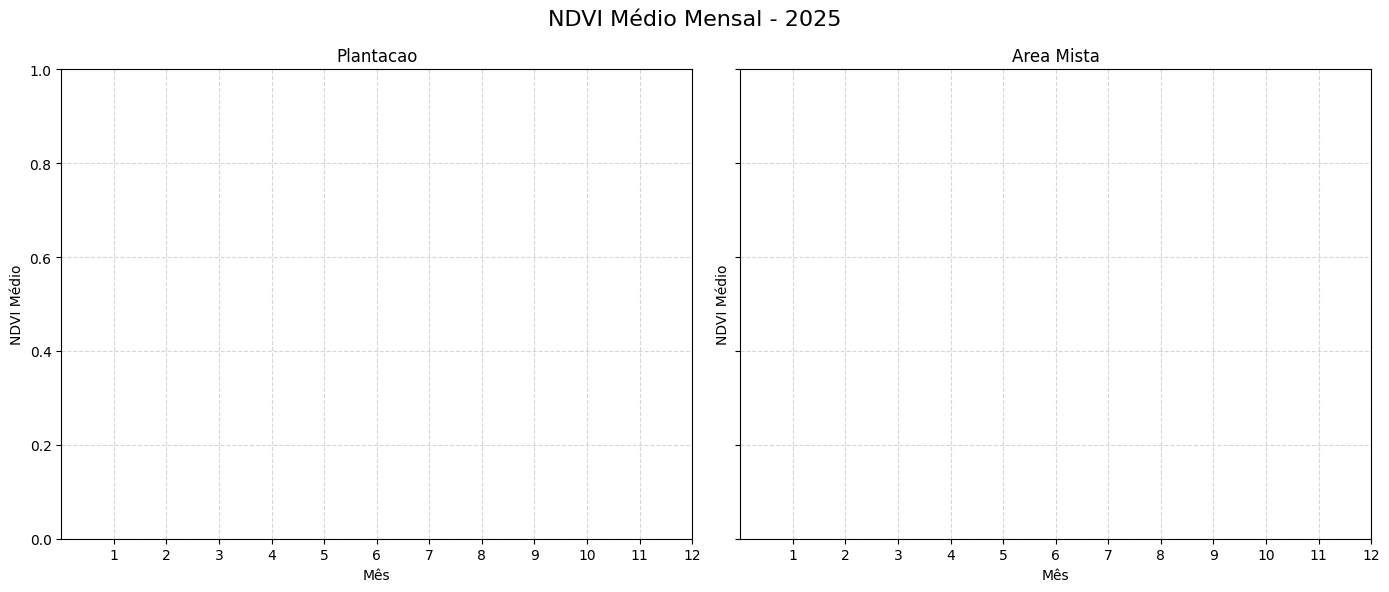

In [15]:
anim = animar_ndvi(df, ['Plantacao', 'Area Mista'])
HTML(anim.to_html5_video())
# salvar como GIF ou MP4
anim.save('ndvi.gif', writer='pillow')

In [16]:
def grafico_ndvi(df: pd.DataFrame, areas_selecionadas: list[str]) -> None:
    df_ano = df.copy()
    df_ano['Ano'] = df_ano['Data'].dt.year
    df_ano['Mes'] = df_ano['Data'].dt.month

    fig, axs = plt.subplots(1, len(areas_selecionadas), figsize=(14, 6), sharey=True)
    if len(areas_selecionadas) == 1:
        axs = [axs]

    for ax, area in zip(axs, areas_selecionadas):
        dados_area = df_ano[df_ano['Area'] == area]

        df_grouped = dados_area.groupby(['Ano', 'Sensor'])['NDVI'].mean().reset_index()

        for sensor in df_grouped['Sensor'].unique():
            dados_sensor = df_grouped[df_grouped['Sensor'] == sensor]
            cor = cor_sensor.get(sensor, 'black')
            ax.plot(dados_sensor['Ano'], dados_sensor['NDVI'], marker='o', label=sensor, color=cor)

        ax.set_title(f'{area}')
        ax.set_xlabel('Ano')
        ax.set_ylabel('NDVI Médio')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    fig.suptitle('Média Anual de NDVI por Área e Sensor', fontsize=16)
    fig.tight_layout()
    plt.show()
    plt.savefig('grafico_ndvi.png')

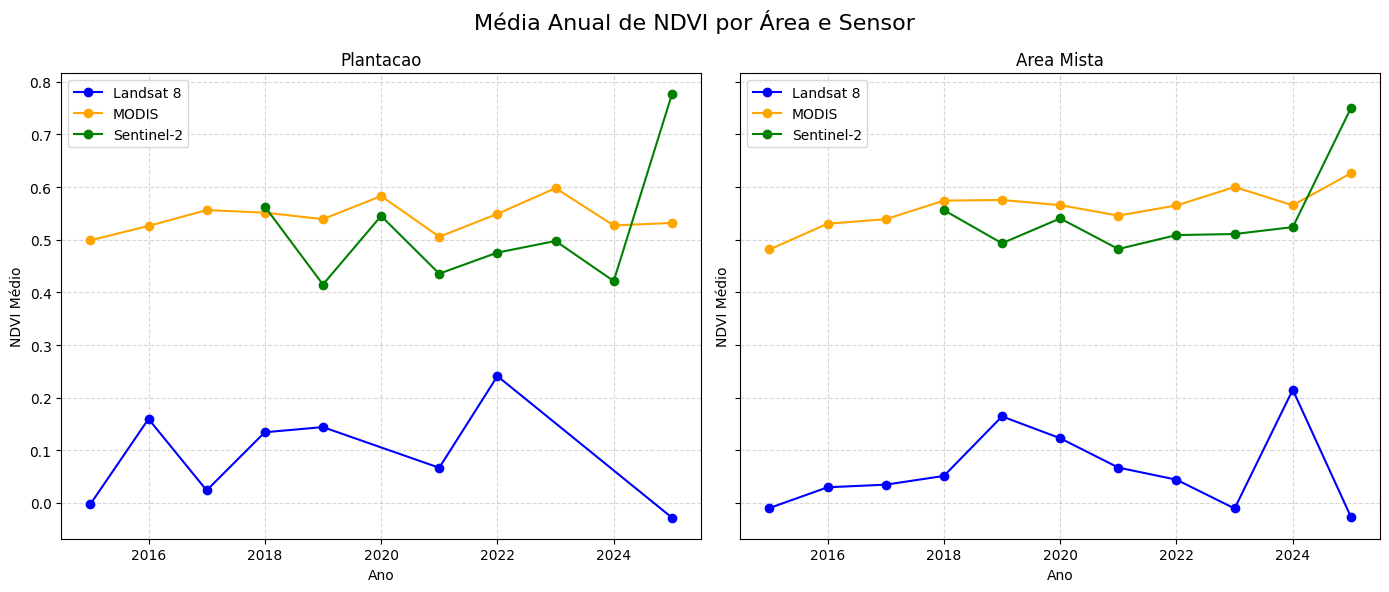

<Figure size 640x480 with 0 Axes>

In [17]:
grafico_ndvi(df, ['Plantacao', 'Area Mista'])